<a href="https://colab.research.google.com/github/ericr6/platform_analysis/blob/main/Voucher_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pandas numpy requests matplotlib seaborn ipywidgets fpdf
# Data handling and manipulation
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# API requests
import requests

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Widgets for user interaction in Google Colab (date selectors)
import ipywidgets as widgets
from IPython.display import display

# PDF generation
from fpdf import FPDF
from google.colab import files


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.5 MB/s eta 0:00:00
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=dd47aba954f5f44bbaa357878263d10aca19b93b7064dd436feee70edd1762b8
  Stored in directory: /root/.cache/pip/wheels/f9/95/ba/f418094659025eb9611f17cbcaf2334236bf39a0c3453ea455
Successfully built fpdf


In [3]:
# GraphQL endpoint
graphql_endpoint = "https://thegraph.bellecour.iex.ec/subgraphs/name/bellecour/iexec-voucher"
# Define the GraphQL query to fetch the voucher data
query = """
{
  vouchers {
    id
    owner {
      id
    }
    expiration
    value
    balance
    voucherType {
      id
      description
      duration  # Adding the duration field
    }
    deals {
      id
      sponsoredAmount
      timestamp
    }
  }
}
"""

# Function to fetch voucher data
def fetch_voucher_data():
    response = requests.post(graphql_endpoint, json={'query': query})

    # Check if the request was successful
    if response.status_code == 200:
        print("Request successful")
        return response.json()
    else:
        raise Exception(f"Query failed with status code {response.status_code}: {response.text}")

# Function to parse and structure data into a DataFrame
def parse_voucher_data(data):
    # Lists for voucher and deal data
    vouchers_data = []
    deals_data = []

    for voucher in data['data']['vouchers']:
        voucher_id = voucher['id']
        owner_id = voucher['owner']['id']
        expiration = int(voucher['expiration'])
        value = int(voucher['value'])
        balance = int(voucher['balance'])
        voucher_type_id = voucher['voucherType']['id']
        type = voucher['voucherType']['description']
        duration = int(voucher['voucherType']['duration'])  # Duration in seconds

        # Add voucher details to vouchers_data
        vouchers_data.append({
            "voucher_id": voucher_id,
            "owner_id": owner_id,
            "expiration": expiration,
            "value": value,
            "balance": balance,
            "voucher_type_id": voucher_type_id,
            "type": type,
            "duration": duration  # Store the duration
        })

        # Extract deals
        for deal in voucher['deals']:
            deal_id = deal['id']
            sponsored_amount = int(deal['sponsoredAmount'])
            timestamp = int(deal['timestamp'])

            # Add deal details to deals_data
            deals_data.append({
                "deal_id": deal_id,
                "voucher_id": voucher_id,
                "sponsored_amount": sponsored_amount,
                "timestamp": timestamp
            })

    # Create DataFrames
    df_vouchers = pd.DataFrame(vouchers_data)
    df_deals = pd.DataFrame(deals_data)

    return df_vouchers, df_deals

# Fetch and parse the data
data = fetch_voucher_data()
df_vouchers, df_deals = parse_voucher_data(data)

# Display the first few rows of the vouchers DataFrame
print("Vouchers DataFrame:")
print(df_vouchers)

# Display the first few rows of the deals DataFrame
print("\nDeals DataFrame:")
print(df_deals.head())


Request successful
Vouchers DataFrame:
                                    voucher_id  \
0   0x0482814093c32b719814c0902baf4cc1806faaf7   
1   0x053ce8865f6237bfc3fa78b16e34cf89a11b07e2   
2   0x0e61f07582394a3a575c5dab6f62408f0a335176   
3   0x132fbb39c5792be1bafa401d3199ddd8cbf35b8c   
4   0x3ee0e40b8424b52eebe98c80c1d1eb8187ce2689   
5   0x43fd2ff3f3e8ae2f734fd6dea5ae354321624561   
6   0x5528dbfebcae54f21c73cec85a210eaad5e6136d   
7   0x57b80c16c7a2a08a309b782a1320896fc31ec610   
8   0x5ebaea1dcd28d630fd808c1a2cb411ccf4981d77   
9   0x6a95de7655bf317604f677c4b293d48aa2cc18ae   
10  0x6be9e346bb052a1c4d3db090dda1c40831fb4346   
11  0x6cf8b06d6da291225443ff03cf1bed67673c8dba   
12  0x6fd00a67b1517173302643e2f027a121f04a17ea   
13  0x9a5cbbba0356cbdeee26c7792b5d08ce4f458949   
14  0x9f6bdc02fb9d5e312cd8742208a63323303329d6   
15  0xa4eba88086f36d8478f0f9ec105c408d968cd9ee   
16  0xab7706da76a84d818fc048b92bf2b80cabc864c7   
17  0xb7d9db31c13332ef47f6a86b4dd10205eefdc604   
18  0xb951e

# Processing the data


In [4]:
# Process data to calculate necessary statistics
def process_data(df_vouchers, df_deals):
    # Calculate the minting date and claim date
    current_timestamp = int(datetime.now().timestamp())

    # Calculate minting date and claim date
    df_vouchers['minting_date'] = df_vouchers['expiration'] - df_vouchers['duration']
    df_vouchers['claim_date'] = pd.to_datetime(df_vouchers['minting_date'], unit='s')

    # Monthly claimed vouchers
    df_vouchers['claimed_month'] = df_vouchers['claim_date'].dt.to_period('M')
    monthly_claimed_vouchers = df_vouchers['claimed_month'].value_counts().reset_index()
    monthly_claimed_vouchers.columns = ['claimed_month', 'num_vouchers_claimed']

    # Monthly RLC circulation
    df_deals['deal_month'] = pd.to_datetime(df_deals['timestamp'], unit='s').dt.to_period('M')
    monthly_rlc_circulation = df_deals.groupby('deal_month')['sponsored_amount'].sum().reset_index()
    monthly_rlc_circulation['sponsored_amount_rlc'] = monthly_rlc_circulation['sponsored_amount'] / 1e9  # Convert to RLC
    monthly_rlc_circulation = monthly_rlc_circulation[['deal_month', 'sponsored_amount_rlc']]  # Select only the relevant columns

    # Consumption Categories
    # Calculate consumption percentage for each voucher
    df_vouchers['conso_%'] = (df_vouchers['value'] - df_vouchers['balance']) / df_vouchers['value'] * 100
    df_vouchers['consumption_category'] = pd.cut(
        df_vouchers['conso_%'],
        bins=[0, 25, 50, 75, 100],
        labels=['0-25%', '25-50%', '50-75%', '75-100%'],
        right=False
    )

    # Count the number of vouchers in each consumption category
    consumption_categories = df_vouchers['consumption_category'].value_counts().rename_axis('consumption_category').reset_index(name='count')

    # Summary Statistics
    total_vouchers_claimed = df_vouchers['voucher_id'].nunique()
    expired_vouchers = df_vouchers[df_vouchers['expiration'] < current_timestamp].shape[0]
    total_rlc_consumed = df_deals['sponsored_amount'].sum() / 1e9  # Convert nanoRLC to RLC
    total_sponsored_deals = df_deals.shape[0]  # Count the total number of deals

    # Calculate average times to consume percentages based on deals
    times_to_consume = {}

    # Loop through each voucher to determine the time taken to reach consumption thresholds
    for index, voucher in df_vouchers.iterrows():
        voucher_id = voucher['voucher_id']
        value = voucher['value']
        claim_date = voucher['claim_date']

        # Get the deals associated with this voucher
        associated_deals = df_deals[df_deals['voucher_id'] == voucher_id]

        # Initialize tracking for consumption
        cumulative_consumed = 0
        time_records = {25: None, 50: None, 75: None, 100: None}

        for _, deal in associated_deals.iterrows():
            deal_amount = deal['sponsored_amount']
            cumulative_consumed += deal_amount
            deal_date = pd.to_datetime(deal['timestamp'], unit='s')

            # Check if the deal date is after the claim date
            if deal_date < claim_date:
                continue

            # Check thresholds and record the time when each threshold is reached
            for percent in time_records.keys():
                if cumulative_consumed >= value * (percent / 100) and time_records[percent] is None:
                    days_to_threshold = (deal_date - claim_date).days
                    time_records[percent] = days_to_threshold

        # Store the time records for this voucher
        for percent in time_records:
            if time_records[percent] is not None:
                if percent not in times_to_consume:
                    times_to_consume[percent] = []
                times_to_consume[percent].append(time_records[percent])

    # Average times to consume for each percentage
    for percent in times_to_consume:
        if times_to_consume[percent]:
            times_to_consume[percent] = sum(times_to_consume[percent]) / len(times_to_consume[percent])
        else:
            times_to_consume[percent] = 'N/A'

    # Return all the processed data
    return {
        "monthly_claimed_vouchers": monthly_claimed_vouchers,
        "monthly_rlc_circulation": monthly_rlc_circulation,
        "consumption_categories": consumption_categories,
        "summary_statistics": {
            "total_vouchers_claimed": total_vouchers_claimed,
            "expired_vouchers": expired_vouchers,
            "total_rlc_consumed": total_rlc_consumed,
            "total_sponsored_deals": total_sponsored_deals,
            "times_to_consume": times_to_consume
        }
    }

# Process the data
data_summary = process_data(df_vouchers, df_deals)

# Output the processed data

tmp = df_vouchers
#print(tmp.head())

# Round the ratio to 2 decimal places
#tmp['consumption_percentage'] = tmp['consumption_percentage'].round(2)
tmp=tmp.sort_values(by='type', ascending=True)
# Print the DataFrame as a formatted table
#print(tmp.to_string(index=False))

# Alternative: If you want a more styled table output
from tabulate import tabulate
print("\nStyled Table Output:")
display_df = tmp.drop(columns=['voucher_type_id','minting_date', 'claimed_month','consumption_category','duration'])
print(tabulate(display_df, headers='keys', tablefmt='pretty', showindex=False))

print("Monthly Claimed Vouchers:")
print(data_summary['monthly_claimed_vouchers'])

print("\nMonthly RLC Circulation:")
print(data_summary['monthly_rlc_circulation'])

print("\nConsumption Categories:")
print(data_summary['consumption_categories'])

print("\nSummary Statistics:")
print(data_summary['summary_statistics'])



Styled Table Output:
+--------------------------------------------+--------------------------------------------+------------+--------------+-------------+--------------------------+---------------------+------------------------+
|                 voucher_id                 |                  owner_id                  | expiration |    value     |   balance   | voucher_type_description |     claim_date      | consumption_percentage |
+--------------------------------------------+--------------------------------------------+------------+--------------+-------------+--------------------------+---------------------+------------------------+
| 0x0482814093c32b719814c0902baf4cc1806faaf7 | 0x02f38d890d079840188edab96235adee1fa568a9 | 1732437500 | 12987012987  |      0      |          build           | 2024-10-25 08:38:20 |         100.0          |
| 0xef4b3cd457ff1e596a90e4f354018f601005875d | 0xaa6628fd4484b0276854a26a69f036c35437353d | 1732374120 | 12658227848  |      0      |          bui

# Graphs generation

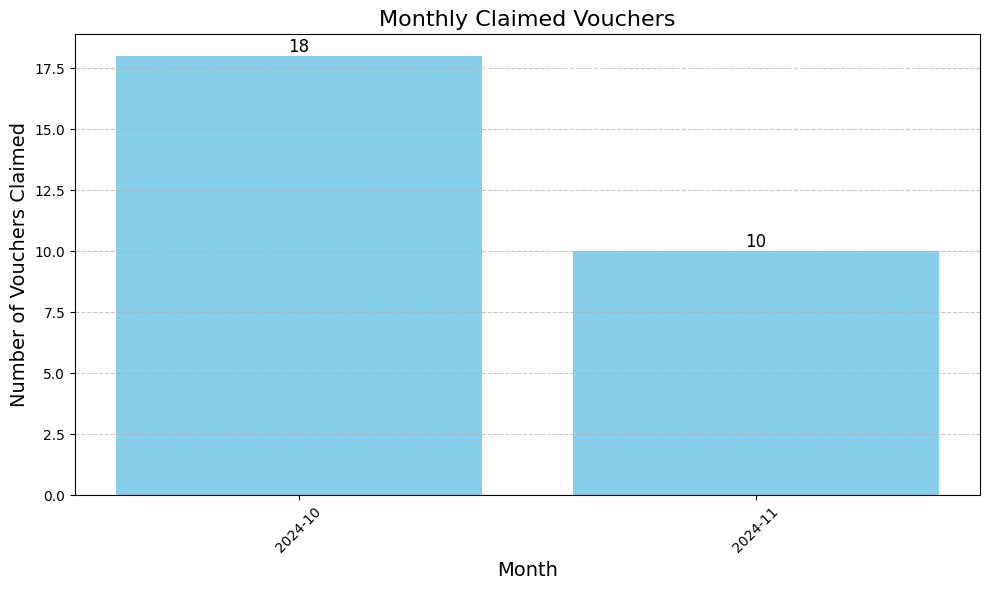

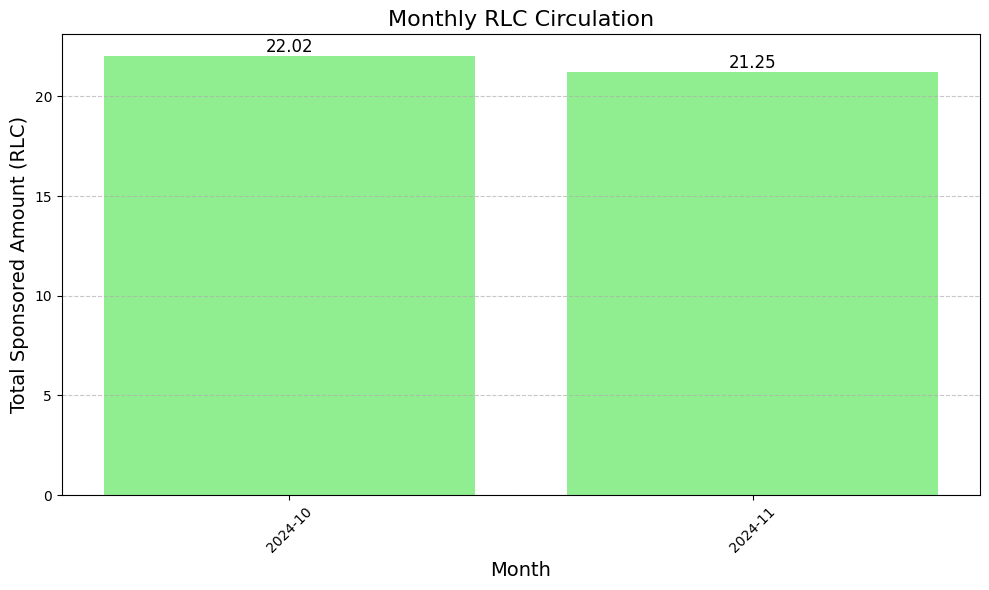

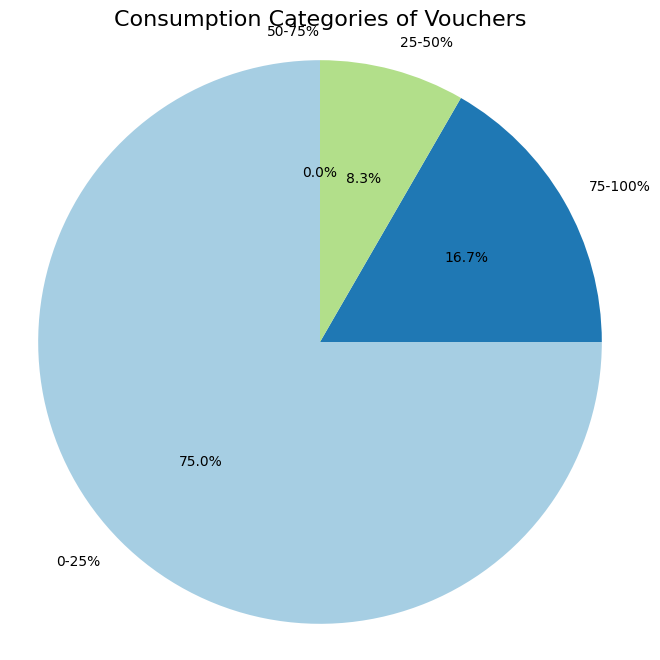

In [ ]:
import matplotlib.pyplot as plt

# Function to plot monthly claimed vouchers
def plot_monthly_claim_growth(data_summary):
    plt.figure(figsize=(10, 6))

    # Bar chart for claimed vouchers
    bars = plt.bar(data_summary['monthly_claimed_vouchers']['claimed_month'].astype(str),
                   data_summary['monthly_claimed_vouchers']['num_vouchers_claimed'], color='skyblue')

    plt.xlabel("Month", fontsize=14)
    plt.ylabel("Number of Vouchers Claimed", fontsize=14)
    plt.title("Monthly Claimed Vouchers", fontsize=16)

    # Adding value labels on top of the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', fontsize=12)

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig("monthly_claim_growth.png")  # Save the figure
    plt.show()

# Function to plot monthly RLC circulation
def plot_monthly_rlc_circulation(data_summary):
    plt.figure(figsize=(10, 6))

    # Bar chart for RLC circulation
    bars = plt.bar(data_summary['monthly_rlc_circulation']['deal_month'].astype(str),
                   data_summary['monthly_rlc_circulation']['sponsored_amount_rlc'], color='lightgreen')

    plt.xlabel("Month", fontsize=14)
    plt.ylabel("Total Sponsored Amount (RLC)", fontsize=14)
    plt.title("Monthly RLC Circulation", fontsize=16)

    # Adding value labels on top of the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', fontsize=12)

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig("monthly_rlc_circulation.png")  # Save the figure
    plt.show()

# Function to plot consumption percentage distribution
def plot_consumption_distribution(data_summary):
    plt.figure(figsize=(8, 8))

    # Pie chart for consumption categories
    labels = data_summary['consumption_categories']['consumption_category']
    sizes = data_summary['consumption_categories']['count']

    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)

    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title("Consumption Categories of Vouchers", fontsize=16)
    plt.savefig("rlc_consumption_percentage_pie.png")  # Save the figure
    plt.show()

# Generate the graphs
plot_monthly_claim_growth(data_summary)
plot_monthly_rlc_circulation(data_summary)
plot_consumption_distribution(data_summary)


# Create the report

In [ ]:
def generate_pdf_report(summary_statistics, consumption_categories, monthly_claimed_vouchers, monthly_rlc_circulation, display_df):
    # Create a PDF instance
    pdf = FPDF()
    
    # Set margins
    pdf.set_margins(10, 10, 10)
    
    # Add a page
    pdf.add_page('L')  # Landscape orientation for the table

    # Set title
    pdf.set_font("Arial", 'B', 16)
    pdf.cell(277, 10, txt="Voucher Usage Report", ln=True, align='C')
    pdf.ln(5)

    # Add some text data
    pdf.set_font("Arial", size=12)
    pdf.cell(277, 10, txt=f"Total Vouchers Claimed: {summary_statistics['total_vouchers_claimed']}", ln=True)
    pdf.cell(277, 10, txt=f"Expired Vouchers: {summary_statistics['expired_vouchers']}", ln=True)
    pdf.cell(277, 10, txt=f"Total RLC Consumed: {summary_statistics['total_rlc_consumed']:.2f} RLC", ln=True)

    # Time to consume percentages
    for percent, days in summary_statistics['times_to_consume'].items():
        pdf.cell(277, 10, txt=f"Average Time to Consume {percent}% of Voucher: {days} days", ln=True)

    # Add Consumption Distribution Info
    pdf.ln(5)
    pdf.set_font("Arial", 'B', 12)
    pdf.cell(277, 10, txt="Consumption Categories:", ln=True)
    pdf.set_font("Arial", size=12)
    for index, row in consumption_categories.iterrows():
        pdf.cell(277, 10, txt=f"{row['consumption_category']}: {row['count']} vouchers", ln=True)

    # Add tabulated data
    pdf.add_page('L')  # Landscape orientation for the table
    pdf.set_font("Arial", 'B', 14)
    pdf.cell(277, 10, txt="Detailed Voucher Data", ln=True, align='C')
    pdf.ln(5)
    
    # Format the DataFrame
    display_df = display_df.copy()
    # Round numeric columns to 2 decimal places
    numeric_columns = display_df.select_dtypes(include=['float64']).columns
    display_df[numeric_columns] = display_df[numeric_columns].round(2)
    
    # Calculate column widths based on content
    headers = display_df.columns.tolist()
    
    # Adjust column widths for landscape mode
    col_widths = []
    for col in headers:
        col_content = display_df[col].astype(str)
        if 'onwer_id' in col.lower():  # For Ethereum addresses
            col_widths.append(90)  # Wider column for addresses
        elif col_content.str.len().max() > 20:
            col_widths.append(50)
        else:
            col_widths.append(30)
    
    # Create table header
    pdf.set_font("Arial", 'B', 10)
    x_position = pdf.get_x()
    for header, width in zip(headers, col_widths):
        pdf.cell(width, 7, str(header), 1, 0, 'C')
    pdf.ln()

    # Create table content with smaller font for better fit
    pdf.set_font("Arial", size=8)
    for _, row in display_df.iterrows():
        x_position = pdf.get_x()
        for value, width in zip(row, col_widths):
            # Truncate long strings if necessary
            value_str = str(value)
            if len(value_str) > 50 and 'address' not in str(value).lower():
                value_str = value_str[:47] + '...'
            pdf.cell(width, 6, value_str, 1, 0, 'C')
        pdf.ln()

    # Add the graphs on portrait pages
    pdf.add_page()  # Back to portrait for graphs
    pdf.image("monthly_claim_growth.png", x=10, y=10, w=180)
    pdf.add_page()
    pdf.image("rlc_consumption_percentage_pie.png", x=10, y=10, w=180)
    pdf.add_page()
    pdf.image("monthly_rlc_circulation.png", x=10, y=10, w=180)

    # Save the PDF
    pdf_file_path = "voucher_report.pdf"
    pdf.output(pdf_file_path)

    # Print formatted table to console
    print("\nStyled Table Output:")
    print(tabulate(display_df, 
                  headers=headers,
                  tablefmt='pretty',
                  showindex=False,
                  floatfmt='.2f',
                  numalign='center',
                  stralign='left'))  # Left align for addresses

    print("\nMonthly Claimed Vouchers:")
    
    return pdf_file_path

# Call the function with the real variables
pdf_file_path = generate_pdf_report(
    summary_statistics=data_summary['summary_statistics'],
    consumption_categories=data_summary['consumption_categories'],
    monthly_claimed_vouchers=data_summary['monthly_claimed_vouchers'],
    monthly_rlc_circulation=data_summary['monthly_rlc_circulation'],
    display_df=display_df
)

# To make the PDF downloadable
files.download(pdf_file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>